In [28]:
!pip install scikit-learn pandas numpy xgboost lightgbm imbalanced-learn

In [29]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from google.colab import files

In [30]:
print("\n📁 Upload your CSV file...")
uploaded = files.upload()
csv_filename = list(uploaded.keys())[0]
print(f"✓ Loaded: {csv_filename}")


📁 Upload your CSV file...


Saving expanded_survey_data.csv to expanded_survey_data (1).csv
✓ Loaded: expanded_survey_data (1).csv


In [31]:
df = pd.read_csv(csv_filename)
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {df.shape[1]}")
print(f"Rows: {df.shape[0]}")



Dataset Shape: (3000, 75)
Columns: 75
Rows: 3000


In [32]:
metadata_cols = ['Time taken', 'source', 'Source details', 'From IP', 'Total points']
company_name_col = '1. What is your software company name? (Optional)'
target_col = '7. Which risk has had the most significant impact on your business over the past year?'


all_cols = df.columns.tolist()
feature_cols = [col for col in all_cols if col not in metadata_cols + [company_name_col, target_col]]

print(f"\n✓ Feature columns: {len(feature_cols)}")
print(f"✓ Target column: {target_col}")


✓ Feature columns: 68
✓ Target column: 7. Which risk has had the most significant impact on your business over the past year?


In [33]:
# Prepare X and y

X = df[feature_cols].fillna(0)
y = df[target_col].fillna('Unknown')

# Check target distribution
print(f"\nTarget Distribution:")
print(y.value_counts())
print(f"\nUnique risk categories: {y.nunique()}")


Target Distribution:
7. Which risk has had the most significant impact on your business over the past year?
No                                                                                              450
Strategic risk                                                                                  300
Loss                                                                                            150
Project churn                                                                                   150
Project competition                                                                             150
Information security                                                                            150
Technology updates too fast                                                                     150
Financial risk                                                                                  150
Market competition, customer demand changes                                                

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Training set: {X_train.shape[0]} samples")
print(f"✓ Test set: {X_test.shape[0]} samples")


✓ Training set: 2400 samples
✓ Test set: 600 samples


In [8]:
print(f"\nEncoding categorical columns...")
non_numeric_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(f"Found {len(non_numeric_cols)} categorical columns")


Encoding categorical columns...
Found 1 categorical columns


In [9]:
if len(non_numeric_cols) > 0:
    X_train = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=False)
    X_test = pd.get_dummies(X_test, columns=non_numeric_cols, drop_first=False)

    # Align columns
    missing_cols = set(X_train.columns) - set(X_test.columns)
    for col in missing_cols:
        X_test[col] = 0
    X_test = X_test[X_train.columns]

    print(f"✓ Encoded shape: {X_train.shape}")

# CRITICAL: Clean column names BEFORE training
print(f"\n🧹 Cleaning column names...")
print("Before cleaning:", X_train.columns[:2].tolist())

✓ Encoded shape: (2400, 85)

🧹 Cleaning column names...
Before cleaning: ['2. How big is your organization?', '3. What type of software development does your company focus on? (Multiple choice) (Web page development)']


In [10]:
X_train.columns = X_train.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)
X_test.columns = X_test.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

print("After cleaning:", X_train.columns[:2].tolist())
print(f" Cleaned {len(X_train.columns)} column names")

# Get cleaned column list
cleaned_feature_cols = X_train.columns.tolist()

# Encode target labels for XGBoost
print(f"\n Encoding target labels...")
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f" Label classes: {le.classes_}")
print(f" Number of classes: {len(le.classes_)}")

After cleaning: ['2_How_big_is_your_organization_', '3_What_type_of_software_development_does_your_company_focus_on_Multiple_choice_Web_page_development_']
 Cleaned 85 column names

 Encoding target labels...
 Label classes: ['Customers delay payment' 'Economic risks' 'Financial risk'
 'Financial risks, operational risks' 'Increased labor costs'
 'Information security' 'Loss'
 'Market competition, customer demand changes' 'No' 'Project churn'
 'Project competition' 'Project loss' 'Shortage of technicians'
 'Strategic risk' 'Technology updates too fast'
 "Upgrades to customers' security compliance requirements lead to large-scale software updates"
 'none']
 Number of classes: 17


In [11]:
print(f"\n Training XGBoost Model...")


xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=len(le.classes_)
)

xgb_model.fit(X_train, y_train_encoded)


 Training XGBoost Model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1, num_class=17, ...)

In [22]:
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(X_train.index.intersection(X_test.index))


(2400, 85) (600, 85)
(2400,) (600,)
Index([], dtype='int64')


In [23]:
[col for col in X.columns if 'risk' in col.lower()]

['5. What types of risks does your software company usually face? (Multiple choice) (Financial risk (budget overspending, funding issues))',
 '5. (Operational risk (ine efficiency of process, poor management))',
 '5. (Strategic risk (market competition, project failure))',
 '5. (Technical risk (system failure, network security threat))',
 '5. (Compliance Risk (Legal and Regulatory Issues))',
 '6. How often will your company encounter unexpected risks?',
 '12. Do you think using AI tools can help your company better manage cost and time risks?',
 '13. Which of the following functions do you want AI tools to have to manage cost/time risks? (Multiple choice) (Cost forecasting and assisting in budgeting work)',
 '14. With 1 to 5 as the level, how severe is the following risks affecting your organization? Â\x97Financial risk',
 '14. Operational Risk',
 '14. Strategic Risk',
 '14. Technical risks',
 '14. Compliance risk',
 '15. With 1 to 5 as the level, how serious is financial risks (such a

In [34]:
y_pred = xgb_model.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"\n Training Complete!")
print(f" Model Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))


 Training Complete!
 Model Accuracy: 0.9600 (96.00%)

Classification Report:
              precision    recall  f1-score   support
Customers dela   0.97       0.94    0.95        30 
Economic risks   0.99       0.94    0.96        72 
Financial risk   0.97       0.93    0.95        113
Financial risk   0.95       0.95    0.95        34 
Increased labo   0.94       0.95    0.94        71 
Information se   0.96       0.96    0.96        52 
Loss             0.95       0.95    0.95        108
Market competi   0.99       0.93    0.96        97 
No               0.95       0.95    0.95        115
Project churn    0.98       0.96    0.97        72 
Project compet   0.97       0.98    0.97        47 
Project loss     0.97       0.94    0.95        100
Shortage of te   0.96       0.96    0.96        110
Strategic risk   0.97       0.97    0.97        59 
Technology upd   0.96       0.95    0.95        100
Upgrades to cu   0.95       0.95    0.95        78 
none             0.94       0.92    

In [13]:
feature_importance = pd.DataFrame({
    'feature': cleaned_feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Save model
print(f"\n Saving model files...")
with open('risk_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("✓ Saved: risk_model.pkl")

# Save cleaned column names
with open('train_columns.pkl', 'wb') as f:
    pickle.dump(cleaned_feature_cols, f)
print(f"✓ Saved: train_columns.pkl ({len(cleaned_feature_cols)} columns)")

# Save label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
print("✓ Saved: label_encoder.pkl")

# Download files
print(f"\nDownloading files...")
files.download('risk_model.pkl')
files.download('train_columns.pkl')
files.download('label_encoder.pkl')


Top 10 Important Features:
                                                                                                                feature  importance
                                23_What_is_the_biggest_challenge_your_organization_faces_in_managing_risks__Inefficient    0.326585
                    23_What_is_the_biggest_challenge_your_organization_faces_in_managing_risks__High_communication_cost    0.318998
                                         23_What_is_the_biggest_challenge_your_organization_faces_in_managing_risks__No    0.039416
                             23_What_is_the_biggest_challenge_your_organization_faces_in_managing_risks__Strategic_risk    0.019452
               23_What_is_the_biggest_challenge_your_organization_faces_in_managing_risks__Technology_iterates_too_fast    0.019452
                   23_What_is_the_biggest_challenge_your_organization_faces_in_managing_risks__Stability_of_technicians    0.019452
                    23_What_is_the_biggest_chall

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

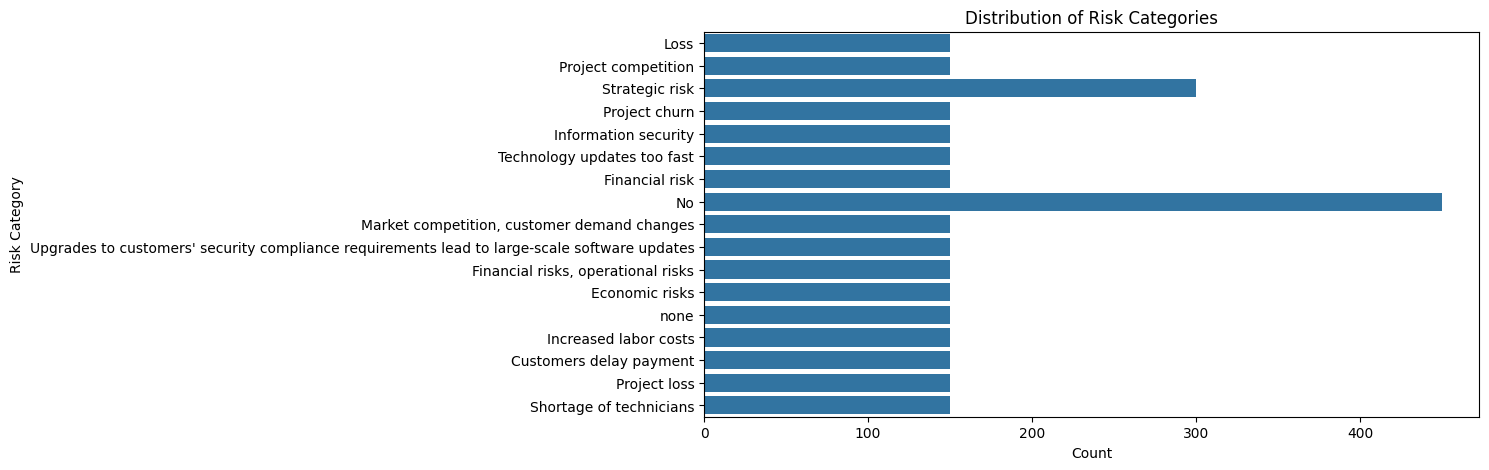

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(y=y)
plt.title("Distribution of Risk Categories")
plt.xlabel("Count")
plt.ylabel("Risk Category")
plt.show()


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 151 (\x97) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


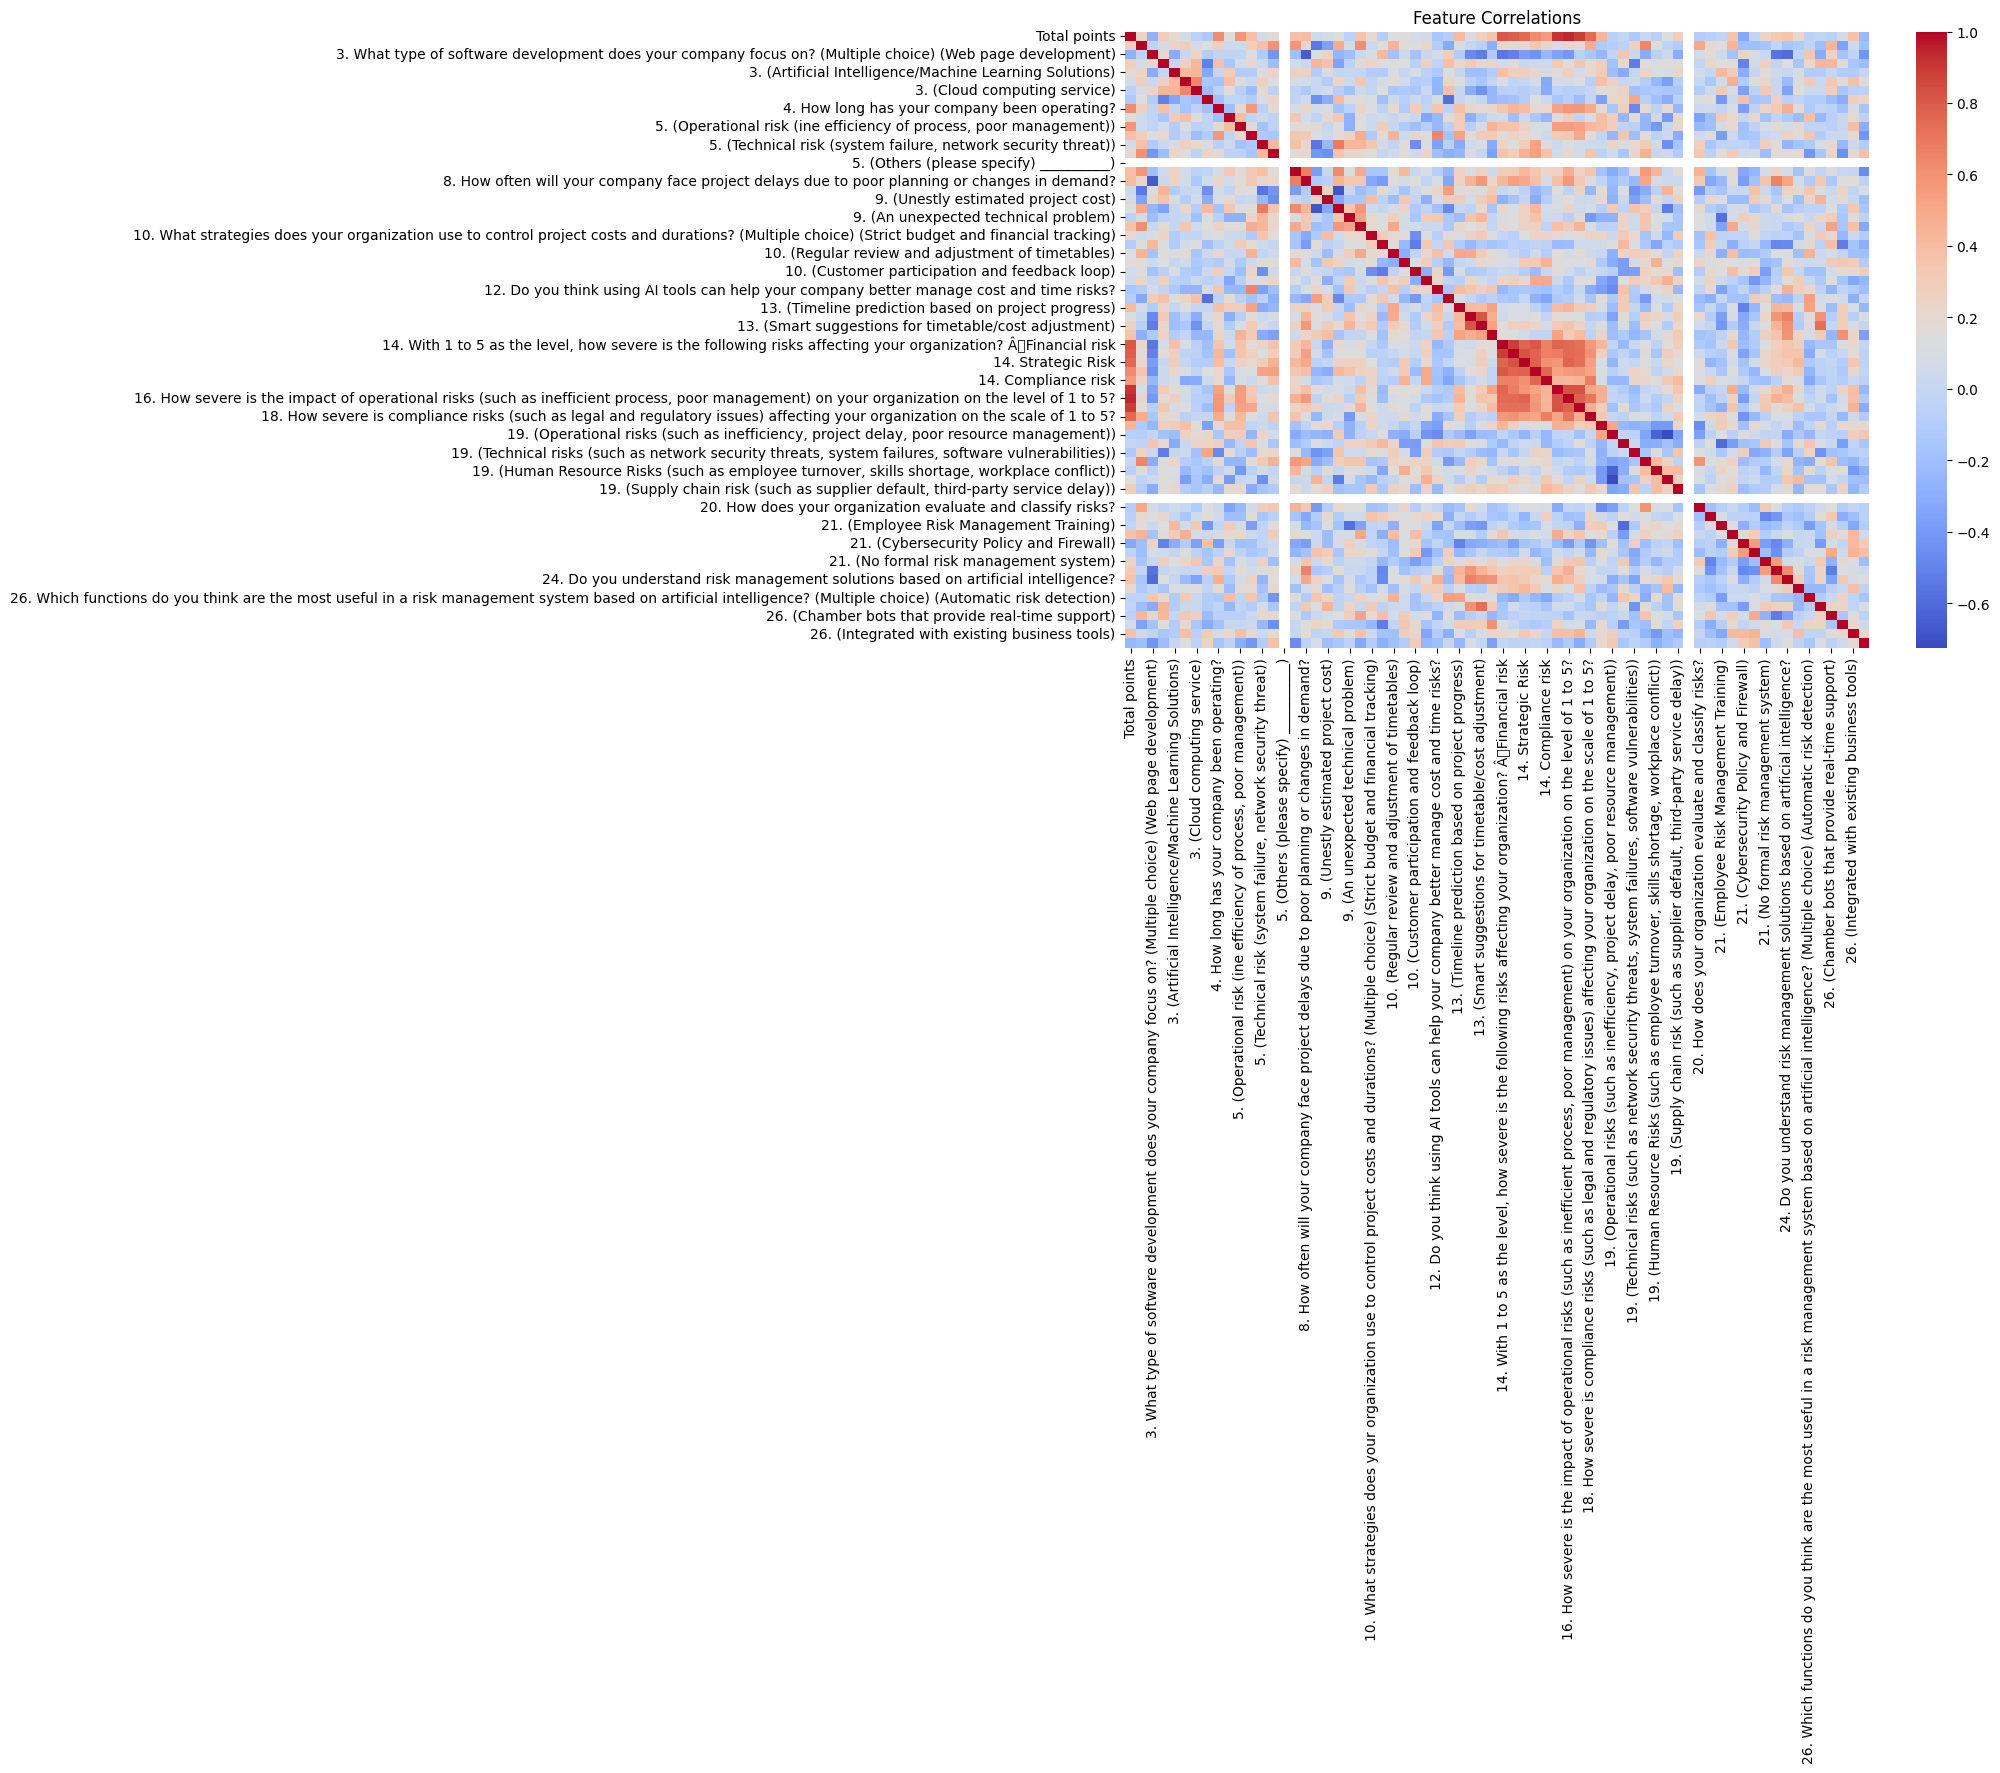

In [15]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()


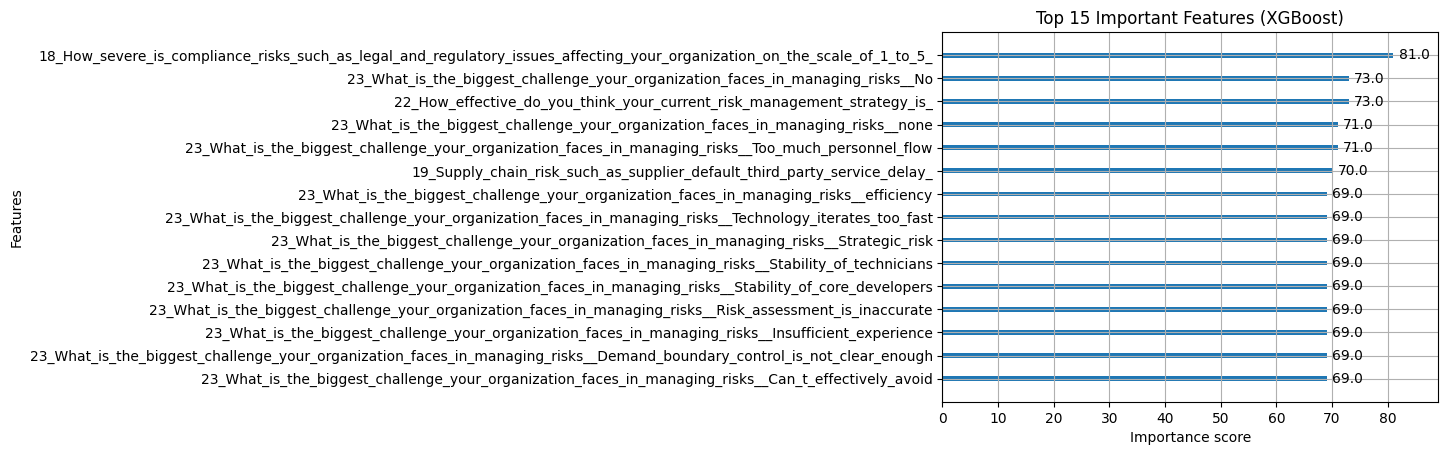

In [16]:
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title("Top 15 Important Features (XGBoost)")
plt.show()


In [18]:
!pip install shap


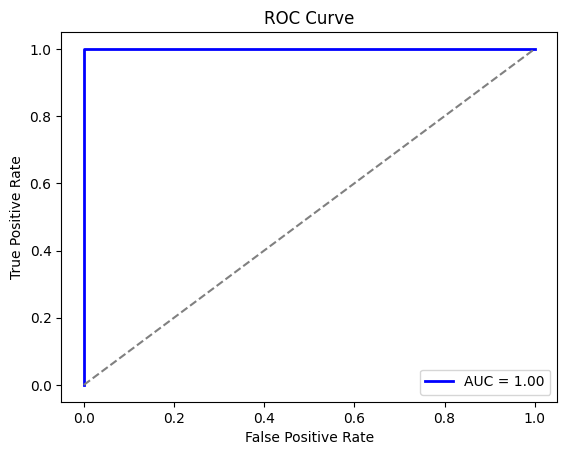

In [20]:
from sklearn.metrics import roc_curve, auc

y_pred_prob = xgb_model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test_encoded, y_pred_prob[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
